# Relationship Extraction - Directed

### Setup 

In [1]:
import networkx as nx
import time
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import stanza
import math
import random
from itertools import combinations, product
%matplotlib inline

In [2]:
# A sample sentence from biomedical domain is used to demonstrate the approach
sent = 'In contrast, the product of the human CDKN2A beta transcript, p14ARF, activates a p53 response manifest in elevated levels of MDM2 and p21CIP1 and cell cycle arrest in both G1 and G2/M.'
print (sent, len(sent.split(' ')))

In contrast, the product of the human CDKN2A beta transcript, p14ARF, activates a p53 response manifest in elevated levels of MDM2 and p21CIP1 and cell cycle arrest in both G1 and G2/M. 32


### Helper Functions 

In [3]:
# Collection of functions that help me process the raw text into a graph using the parsing result.
def spanner(sentence, return_raw=False):
    """ 
    recombine tokens into entity based on 'ner' indicator 
    input: a raw sentence
    output: a stanza Doc object re-tokenized based on combination of terms that are biomedically relevant
    """
    # Using stanford NLP developed Stanza to process the sentence
    # bionlp13cg is a corpus used for NER task on biomedical related text
    pretokenized_nlp = stanza.Pipeline('en', package='craft', processors={'ner': 'bionlp13cg'}, tokenize_pretokenized=True)
    nlp = stanza.Pipeline('en', package='craft', processors={'ner':'bionlp13cg'})
    
    doc = nlp(sentence)
    cur_ent = []
    tokenized_sent = []
    
    # Recombine tokens based on NER result instead of raw tokens
    for sent in doc.sentences:
        for token in sent.tokens:
            if (token.ner == "O" or token.ner.startswith('S-')):
                tokenized_sent.append(token.text)
            elif token.ner.startswith('B-') or token.ner.startswith('I-'):
                cur_ent.append(token.text)
            elif token.ner.startswith('E-'):
                cur_ent.append(token.text)
                new_span = ' '.join(cur_ent)
                if ' - ' in new_span:
                    new_span = new_span.replace(' - ','-')
                tokenized_sent.append(new_span)
                cur_ent = []
            else:
                pass
    # control the return; whether to return a stanza doc object or raw text
    if return_raw:
        return tokenized_sent, len(tokenized_sent)
    else:
        retokenized_doc = pretokenized_nlp([tokenized_sent])
        return retokenized_doc, len(tokenized_sent)
    
def consolidatedPassSpanner(doc):
    """
    A custom built function to combine certain tokens together
    Currently, there are two basic recombination rules
    1. recombine two consecutive tokens that are both 'NOUN'
    2. recombine two consecutive tokens that are part of the 'VERB' in passive voice
    Input: a stanza doc
    Output: a retokenized stanza doc
    '"""
    retokenized_txt = []
    for sent in doc.sentences:
        count = 0
        while count < len(sent.words):
            if count+1<len(sent.words) and (sent.words[count].upos == 'NOUN' and sent.words[count].xpos=='NN') and (sent.words[count+1].upos=='NOUN' and sent.words[count+1].xpos=='NN'):
                retokenized_txt.append(' '.join([sent.words[count].text, sent.words[count+1].text]))
                count +=2
            elif count+1<len(sent.words) and sent.words[count].upos == 'AUX' and sent.words[count+1].upos=='VERB':
                retokenized_txt.append(' '.join([sent.words[count].text, sent.words[count+1].text]))
                count +=2
            else:
                retokenized_txt.append(sent.words[count].text)
                count +=1
    return retokenized_txt

def dynamicReSpanner(doc, length):
    """
    A custom built function to recombine tokens using function consolidatedPassSpanner.
    This function will dynamically recombine the tokens based on its last POS tag until there is no
    further feasible recombination.
    """
    pretokenized_biomedicalnlp = stanza.Pipeline(lang='en', package='craft', processors={'ner': 'bionlp13cg'}, tokenize_pretokenized=True) 
    prev_size = length
    while True:
        pretokenized_sent = consolidatedPassSpanner(doc)
        doc = pretokenized_biomedicalnlp([pretokenized_sent])
        next_size = len([word.text for sent in doc.sentences for word in sent.words])
        print ('Prev size: %i Vs. Next size %i' %(prev_size, next_size))
        if next_size == prev_size:
            break
        else:
            prev_size=next_size
    return doc

def spannerWrapper(sent):
    """
    A function to combine the functions "dynamicReSpanner" and "spanner" to allow more complex operation
    on the sentence
    """
    doc_1, length = spanner(sent)
    doc_2 = dynamicReSpanner(doc_1, length)
    return doc_2

def printDoc(doc):
    print(*[f'id: {word.id}\tword: {word.text.ljust(25, " ")}\tupos: {word.upos.ljust(6, " ")}\txpos: {word.xpos.ljust(6, " ")}\thead: {sent.words[word.head-1].text.ljust(15, " ") if word.head > 0 else "root"}' for sent in doc.sentences for word in sent.words], sep='\n')


In [4]:
# Collection of functions that allows me to construct a graph representing the sentence structure
def createTokenDiGraphwithContraction(doc):
    g = nx.DiGraph()
    # dependency chain that reflects the connection between words based on dependency parsing output
    # https://stanfordnlp.github.io/stanza/depparse.html
    # I am using the syntactic head of each word in a sentence and the dependency relation 
    # between the two words that are accessible through Word’s head and deprel attributes
    # to construct the graph.
    # In addition, I add a linear directed link between adjacent tokens to represent the sequence of tokens.
    # Note: all node and edge weights are initiated with a value of 1.
    
    # Connection between token and its head
    for sent in doc.sentences: 
        for word in sent.words:
            tail = word.text
            tail_dep = word.deprel
            tail_nature = word.upos
            head = sent.words[word.head-1].text
            head_dep = sent.words[word.head-1].deprel
            head_nature = sent.words[word.head-1].upos
            g.add_node(head, deprel=head_dep, pos=head_nature, weight=1)
            g.add_node(tail, deprel=tail_dep, pos=tail_nature, weight=1)
            g.add_edge(head, tail, weight=1)
    # linear chain that reflects the order of words in the sentence
    for sent in doc.sentences: 
        for i in range(len(sent.words)-1):
            g.add_edge(sent.words[i].text, sent.words[i+1].text, weight=1)
    # Remove the end '#' if present and punctuation        
    h = contract(g)
    h = removePunct(h)
    return h

def contract(g):
    # function to remove an '#' that indicates the end of a sentence
    if '#' in g.nodes:
        for n in g.neighbors('#'):
            if g.nodes[n]['pos']=='VERB' or g.nodes[n]['pos']=='PART' or g.nodes[n]['pos']=='AUX' or g.nodes[n]['pos']=='NOUN' or g.nodes[n]['pos']=='PROPN':
                h = nx.contracted_nodes(g, n, '#')
                return h
            else:
                return g
    else:
        return g

def removePunct(g):
    # function to remove any punctuation that is not relevant to the explanation
    nodes_lst = list(g.nodes)
    for node in nodes_lst:
        if g.nodes[node]['pos'] =='PUNCT':
            g.remove_node(node)
    return g

def plot_network(graph):
    # A simple function to plot the graph constructed by function "createTokenDiGraphwithContraction"
    plt.figure(figsize=(20,20))
    pos = nx.spring_layout(graph)
    nx.draw_networkx_nodes(graph, pos, node_color='r')
    nx.draw_networkx_labels(graph, pos, font_size = 14)
    nx.draw_networkx_edges(graph, pos, edge_color='b')
    plt.show()


In [5]:
# Collection of functions to transverse the graph in order to collect information about the structure
def updateNodeWt(G):
    """
    A way to skew the walk towards a sequence of tokens that follow S-V-O in grammar
    Input: a networkx Graph
    Output: a networkx Graph with updated node weight
    """
    pos = nx.get_node_attributes(G, 'pos')
    for node, pos in pos.items():
        if pos=='VERB' or node=='not':
            G.nodes[node]['weight']=math.exp(2) # ~ 7.38905609893
        elif pos=='NOUN':
            G.nodes[node]['weight']=math.exp(1) # ~ 2.71828182846
        else:
            G.nodes[node]['weight']=math.exp(0) # = 1
    return G

def updateEntWt(G, doc):
    """
    Input: a networkx Graph
    Output: a networkx Graph with updated entity weight, replace the assignment under UpdateNodeWt() function
    """    
    ents = [ent.text for sent in doc.sentences for ent in sent.ents if ent.type=='GENE_OR_GENE_PRODUCT']
    print (ents)
    for node in G.nodes():
        if node in ents:
            G.nodes[node]['weight']=math.exp(3) # ~ 20.0855369232
    return G

def updateEdgeWt(G):
    """
    Input: a networkx Graph
    Output: a networkx Graph with updated edge weight
    """    
    edges = nx.get_edge_attributes(G, 'weight')
    nodes = nx.get_node_attributes(G, 'weight')
    for edge, weight in edges.items():
        G.edges[edge]['weight'] = math.sqrt(nodes[edge[0]]*nodes[edge[1]])
    return G

def get_Weighted_Neighbours(G, node):
    """ 
    Generate a list of neighbours of a node with its corresponding transition probability
    i.e. Pr(token_next | token_curr)
    """
    if node in G.nodes:
        node_weights = nx.get_node_attributes(G, "weight")
        
        # Prepare neighbour list and obtain weight of each attribute for nodes and edges
        edge_wgts = nx.get_edge_attributes(G, "weight")
        node_neighbours = [adj_node for adj_node, datadict in G[node].items()]
        self_node_wgt = np.array(len(node_neighbours))*node_weights[node]
        neighbour_wgts = [datadict['weight'] for adj_node, datadict in G[node].items()]
        neighbour_pair_wgts = list()
        for neigbhour in node_neighbours:
            neighbour_pair_wgts.append(edge_wgts[(node, neigbhour)])

        # Calculate the transition probability from start node to respective neighbour
        elementwise_wgts = np.multiply(self_node_wgt, np.array(neighbour_wgts), np.array(neighbour_pair_wgts))
        total_weight = sum(elementwise_wgts)
        neighbour_prob = [weight/total_weight for weight in elementwise_wgts]
    else:
        return ['null'], [0]
    return node_neighbours, neighbour_prob

def get_nextNode(G, node):
    """ 
    obtain next node of a given start_node
    """
    neighbour_list, neighbour_prob = get_Weighted_Neighbours(G, node)
    if len(neighbour_list)!=0 and neighbour_list[0]!='null':
        next_node = random.choices(neighbour_list, neighbour_prob)
    else:
        next_node = ['null']
    return next_node

def get_random_walk(graph, node, n_steps):  
    """ 
    Given a graph, a node and its sentence
    return a random walk starting from the node 
    """
    local_path = [node]
    for i in range(n_steps):
        next_node = get_nextNode(graph, node)
        if next_node[0] != 'null': # terminate the walk if it hits a signifying terminal node 'null'
            local_path.append(next_node[0])
            node = next_node[0]
        else:
            return local_path
    return local_path


In [6]:
# Collection of functions to calculate Bayes probability
def BayesProb(target, conditional, ps):
    """
    Calculate conditional probability
    Input:
    Target = numerator of the probility function
    conditional_on = denominator of the probability function
    p = a collection of random walks
    Output:
    a conditional probability
    Note: it doesn't take into consideration of the adjancency of two nodes in counting 
    the number of occurence
    """
    numerator = 0
    denominator = 0
    all_elements = target + conditional
    print (all_elements, conditional)
    for p in ps:
        if len(set(all_elements).intersection(set(p)))==len(set(all_elements)):
            numerator +=1
        if len(set(conditional).intersection(set(p)))==len(set(conditional)):
            denominator +=1
    print ('Numerator: %i; Denominator: %i' %(numerator, denominator))
    if denominator==0:
        Pr = 0
        print (('Pr(' + str(target) +'|' + str(conditional)+')' + ': %.6f') %(Pr))
        return Pr
    else:
        Pr = numerator/denominator
        print (('Pr(' + str(target) +'|' + str(conditional)+')' + ': %.6f') %(Pr))
        return Pr
    

### Preprocessing the raw text 

In [7]:
doc = spannerWrapper(sent)
printDoc(doc)

2022-10-08 08:27:29 INFO: Loading these models for language: en (English):
| Processor | Package    |
--------------------------
| tokenize  | craft      |
| pos       | craft      |
| lemma     | craft      |
| depparse  | craft      |
| ner       | bionlp13cg |

2022-10-08 08:27:29 INFO: Use device: cpu
2022-10-08 08:27:29 INFO: Loading: tokenize
2022-10-08 08:27:29 INFO: Loading: pos
2022-10-08 08:27:29 INFO: Loading: lemma
2022-10-08 08:27:29 INFO: Loading: depparse
2022-10-08 08:27:29 INFO: Loading: ner
2022-10-08 08:27:29 INFO: Done loading processors!
2022-10-08 08:27:29 INFO: Loading these models for language: en (English):
| Processor | Package    |
--------------------------
| tokenize  | craft      |
| pos       | craft      |
| lemma     | craft      |
| depparse  | craft      |
| ner       | bionlp13cg |

2022-10-08 08:27:29 INFO: Use device: cpu
2022-10-08 08:27:29 INFO: Loading: tokenize
2022-10-08 08:27:29 INFO: Loading: pos
2022-10-08 08:27:29 INFO: Loading: lemma
2022

Prev size: 36 Vs. Next size 33
Prev size: 33 Vs. Next size 32
Prev size: 32 Vs. Next size 32
id: 1	word: In                       	upos: ADP   	xpos: IN    	head: contrast       
id: 2	word: contrast                 	upos: NOUN  	xpos: NN    	head: activates      
id: 3	word: ,                        	upos: PUNCT 	xpos: ,     	head: activates      
id: 4	word: the                      	upos: DET   	xpos: DT    	head: product        
id: 5	word: product                  	upos: NOUN  	xpos: NN    	head: activates      
id: 6	word: of                       	upos: ADP   	xpos: IN    	head: CDKN2A beta transcript
id: 7	word: the                      	upos: DET   	xpos: DT    	head: CDKN2A beta transcript
id: 8	word: human                    	upos: ADJ   	xpos: JJ    	head: CDKN2A beta transcript
id: 9	word: CDKN2A beta transcript   	upos: NOUN  	xpos: NN    	head: product        
id: 10	word: ,                        	upos: PUNCT 	xpos: ,     	head: CDKN2A beta transcript
id: 11	word: p14AR

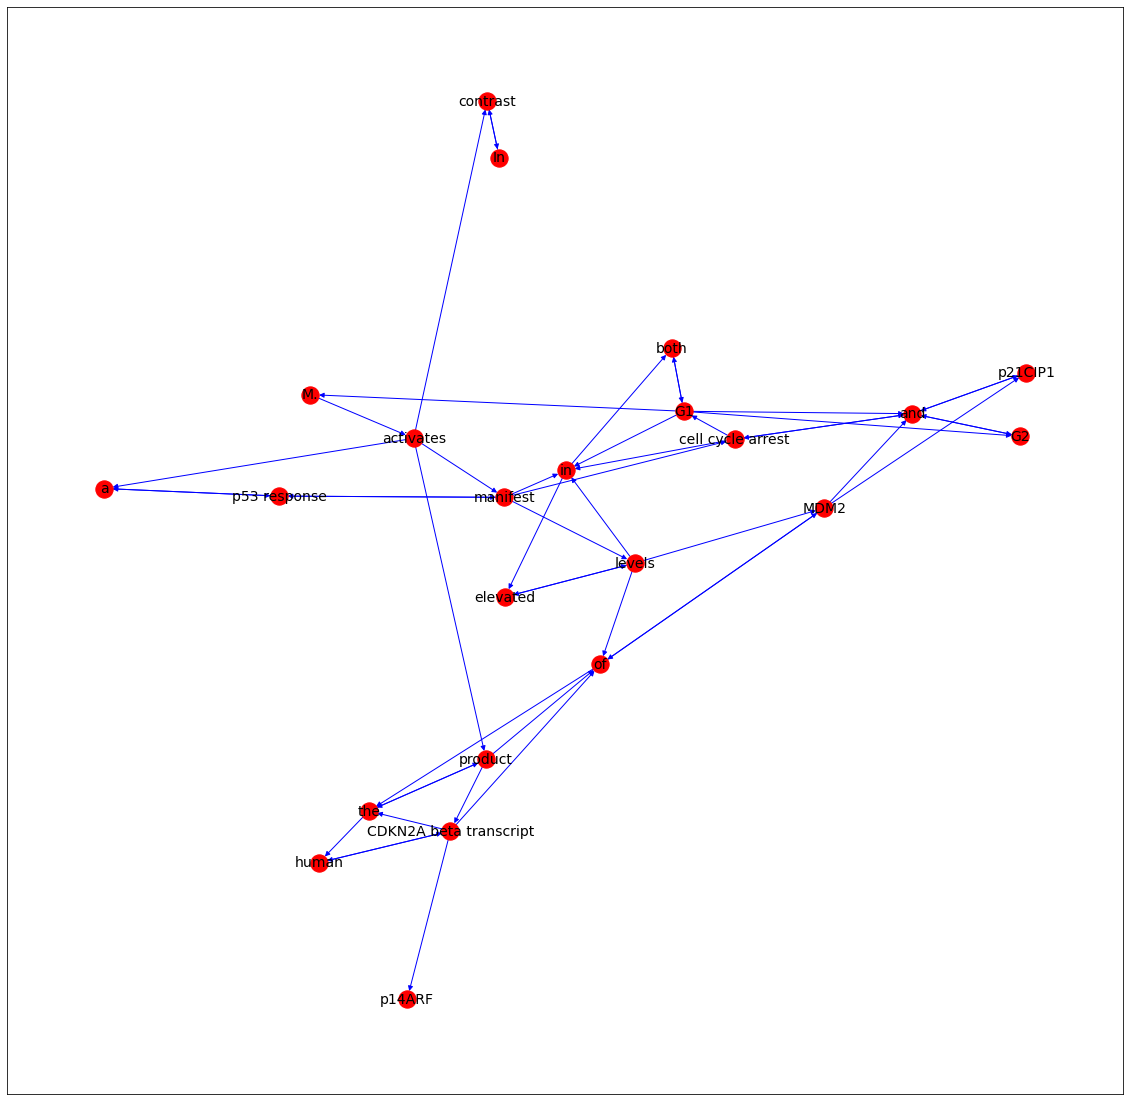

CPU times: user 700 ms, sys: 811 ms, total: 1.51 s
Wall time: 223 ms


In [8]:
%%time
# Construction of a graph that represent the sample sentence
G = createTokenDiGraphwithContraction(doc)
plot_network(G)

In [21]:
nx.is_directed_acyclic_graph(G)

False

In [9]:
# the Eigenvalue centrality score of each node
centrality = nx.eigenvector_centrality(G)
pairs = sorted(centrality.items(), key=lambda x:x[1], reverse=True)
pairs
# From below result, it is expected those connective words, such as "and", will receive high centrality scores.
# Since I did not normalise the text to correct the Cap and non-Cap version (i.e. In and in) of words,
# they receive different centrality score because, like, "In" appears at the begining of the sentence
# while "in" is in the middle of the sentence connecting different words to form an adjective phrase
# of object 'p53 response'. I will ignore the centrality for the time being and use the default status
# to see if a random walk model could capture the underlying directed relationship.

[('and', 0.586915745217649),
 ('G2', 0.3650261801099659),
 ('p21CIP1', 0.3173651397614822),
 ('in', 0.28257856179243845),
 ('cell cycle arrest', 0.2784711240788107),
 ('both', 0.22858914970284683),
 ('G1', 0.22731794676147446),
 ('of', 0.1796160908671824),
 ('elevated', 0.16715891275379535),
 ('the', 0.16541643823907878),
 ('MDM2', 0.12100229083108764),
 ('human', 0.11662212134605611),
 ('M.', 0.10190781923525932),
 ('CDKN2A beta transcript', 0.0947137846588995),
 ('product', 0.09464073264440051),
 ('levels', 0.09029072772069356),
 ('activates', 0.04568576217531113),
 ('p14ARF', 0.04246251102238868),
 ('a', 0.03424645171443325),
 ('manifest', 0.03424645171443325),
 ('p53 response', 0.030705526408208297),
 ('contrast', 0.025632657486139673),
 ('In', 0.011491203766063792)]

### Random walk transversing the graph 

In [10]:
# Basically, I follow the practise as documented in the following wiki page
# The only difference is the random walk as documented there follows a regular graph.
# That means the transition probabolity is symmetric in all direction while this is not true in current case.
# But I still go ahead with the approach to analyse the graph structure of this particular construction approach.
from IPython.display import IFrame
display(IFrame('https://en.wikipedia.org/wiki/Random_walk', 900, 300))

In [11]:
%%time
# Collect a batch of random walks generated by this particular graph construction of this sentence
rw = []
walk_length = len(sent.split(' '))*2
for i in range(500): # each node will receive 500 random walks
    for node in G.nodes:
        ps = get_random_walk(G, node=node, n_steps=walk_length)
        rw.append(ps)
len(rw)

CPU times: user 13.4 s, sys: 18.7 ms, total: 13.4 s
Wall time: 13.4 s


11500

In [12]:
%%time
# collect the frequency of each token transvered
dict_data = dict()
for node in G.nodes:
    dict_data[node] = 0
for walk in rw:
    for entry in walk:
        dict_data[entry] += 1

CPU times: user 41.6 ms, sys: 866 µs, total: 42.5 ms
Wall time: 42.1 ms


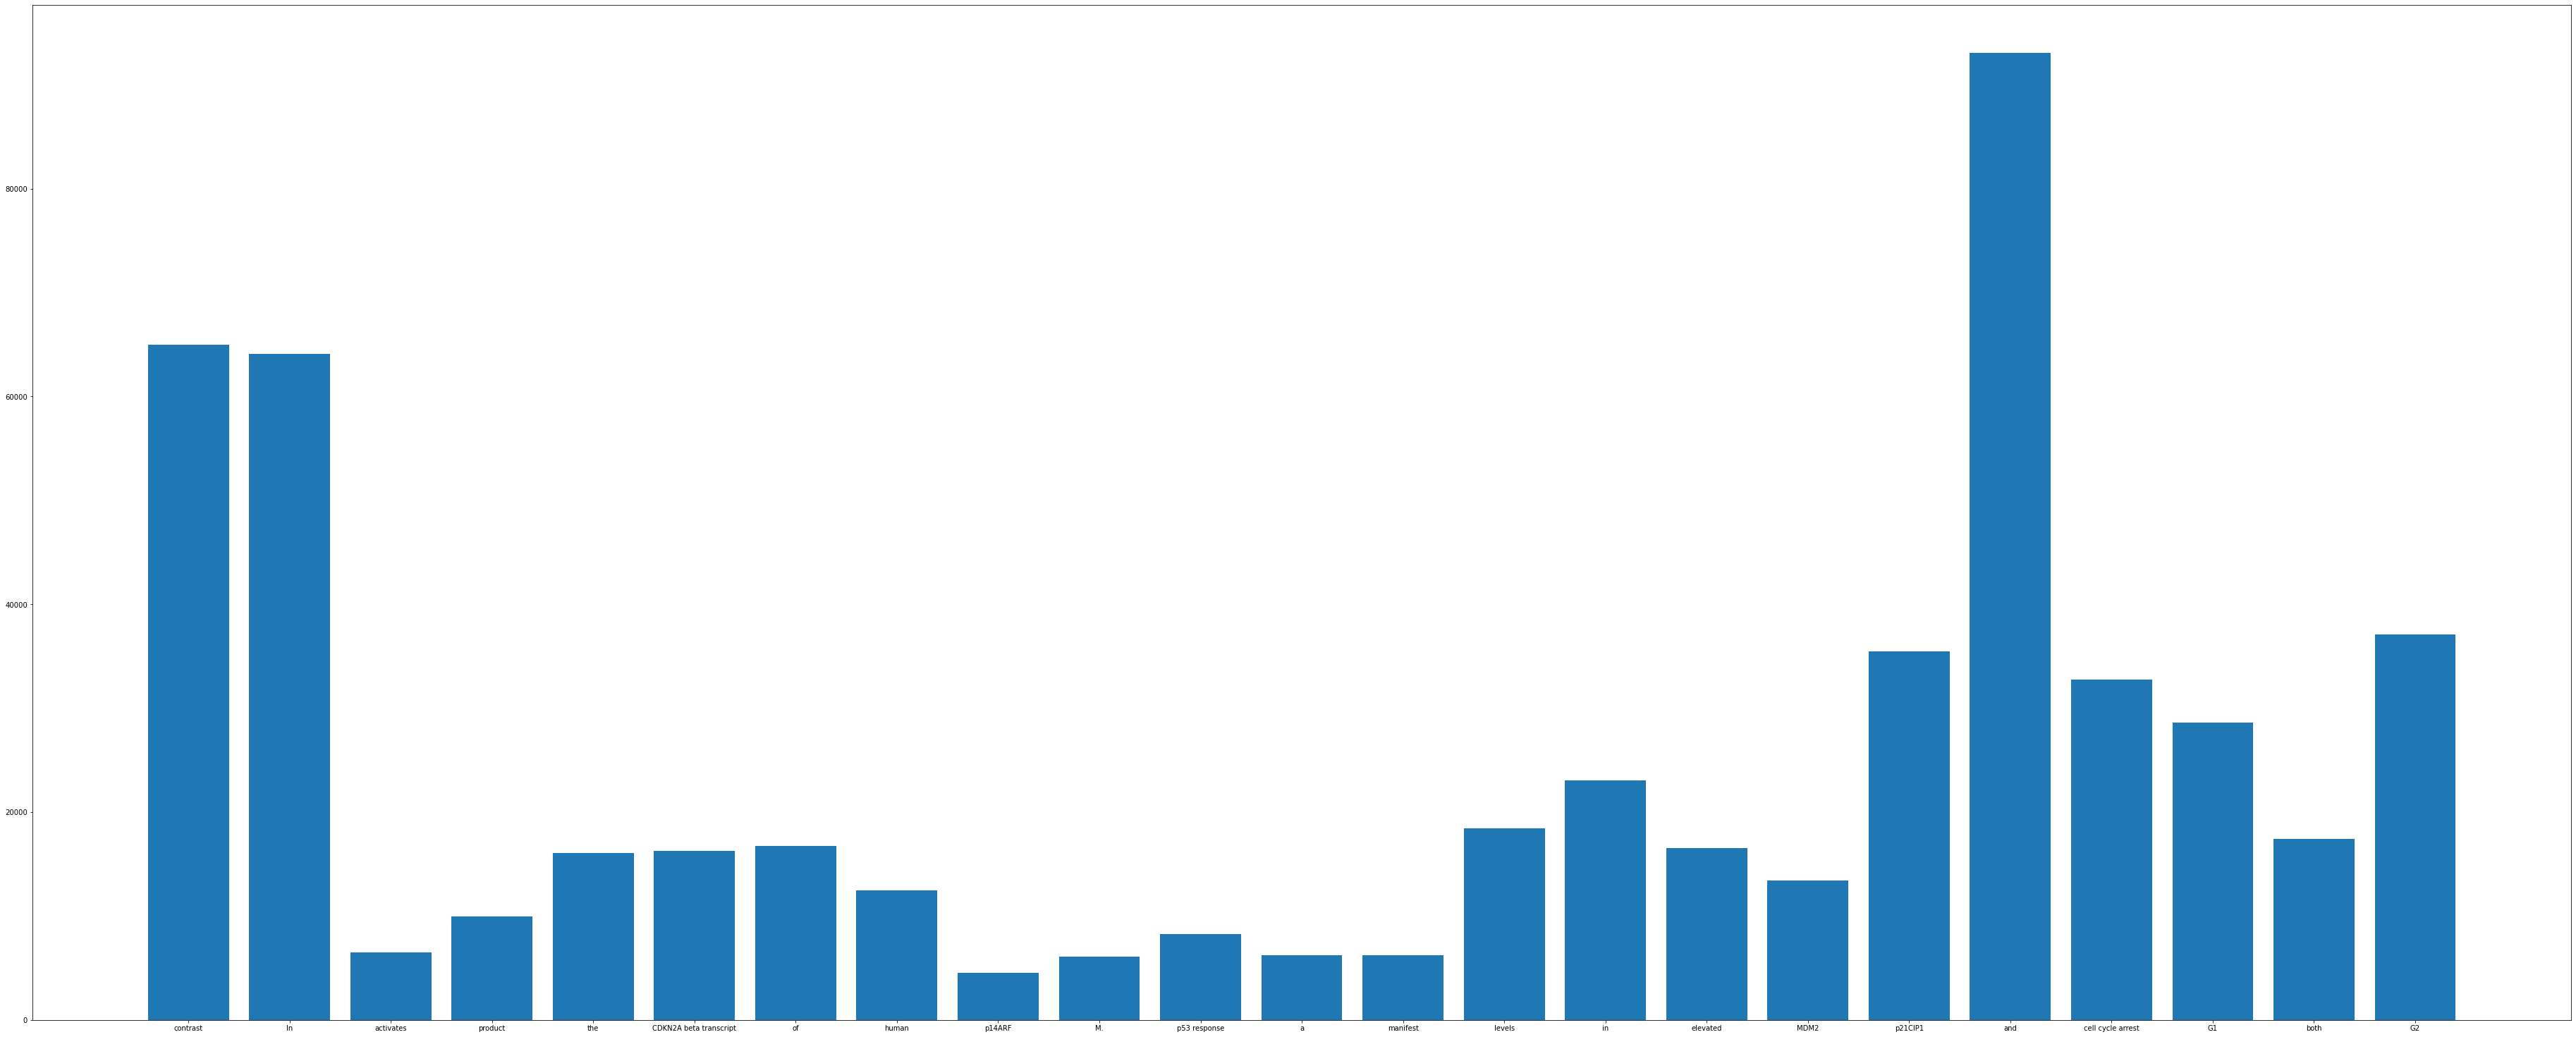

In [13]:
# Bar diagram to display the frequencies of each token in the random walks
# It's apparent that most frequent token 'and' also has the largest eigenvalue.
# Surprise is 'In' and 'Contrast' these two tokens also have high frequencies while their corresponding
# eigenvalues are bottom two. This might have to do with the eigen_centrality measures does not 
# provide a good measure of the directionality of a DiGraph.
from matplotlib.pyplot import figure
fig = figure(figsize=(50, 20))
ax = fig.add_axes([0,0,1,1])
tokens = list(dict_data.keys())
counts = dict_data.values()
ax.bar(tokens,counts)
plt.show()

### Bayesian Analysis on the conditional probability 

In [14]:
# A sample case to demonstrate asymmetry between two entities of interest
# Background: CDKN2A has two distinct trancription products. One is p14ARF and the other is p16INK4A
# So the likelihood of CDKN2A -> p14ARF will have lower probability because it's one of the two option
BayesProb(target=['p14ARF'], conditional=['CDKN2A beta transcript'], ps=rw)

['p14ARF', 'CDKN2A beta transcript'] ['CDKN2A beta transcript']
Numerator: 4044; Denominator: 6036
Pr(['p14ARF']|['CDKN2A beta transcript']): 0.669980


0.6699801192842942

In [15]:
# On the other hand, p14ARF can only be found when CDKN2A is expressed as beta trasncript.
# There is no other way to happen.  Hence, after accounting the noise (i.e. irrelevant tokens in the sentence),
# the likelihood of p14ARF -> CDKN2A should be higher.
# And that could be explained by the topology of the sent-graph.  
# Node 'CDKN2A beta transcript' has directed egde to token 'p14ARF'. Yet there is no returned edge.
# That can be explained as a markov chain: the more options you can move onto from current node, 
# the lower the transition probility for each next node.
BayesProb(target=['CDKN2A beta transcript'], conditional=['p14ARF'], ps=rw)

['CDKN2A beta transcript', 'p14ARF'] ['p14ARF']
Numerator: 4044; Denominator: 4544
Pr(['CDKN2A beta transcript']|['p14ARF']): 0.889965


0.8899647887323944

#### Testing the SVO structure and mediator impact

In [16]:
# A more complicated example
# In biomedical literature, we know CDKN2A expression is associated MDM2 expression.
# But we are not sure about the underlying mechanism. Whether any mediator or confounder is controlling the expression
# of the two entities.
BayesProb(target=['MDM2'], conditional=['CDKN2A beta transcript'], ps=rw)

['MDM2', 'CDKN2A beta transcript'] ['CDKN2A beta transcript']
Numerator: 3735; Denominator: 6036
Pr(['MDM2']|['CDKN2A beta transcript']): 0.618787


0.6187872763419483

In [17]:
BayesProb(target=['MDM2'], conditional=['activates','CDKN2A beta transcript'], ps=rw)

['MDM2', 'activates', 'CDKN2A beta transcript'] ['activates', 'CDKN2A beta transcript']
Numerator: 1929; Denominator: 2461
Pr(['MDM2']|['activates', 'CDKN2A beta transcript']): 0.783828


0.7838277123120683

In [18]:
BayesProb(target=['MDM2'], conditional=['p53 response','activates','CDKN2A beta transcript'], ps=rw)

['MDM2', 'p53 response', 'activates', 'CDKN2A beta transcript'] ['p53 response', 'activates', 'CDKN2A beta transcript']
Numerator: 825; Denominator: 977
Pr(['MDM2']|['p53 response', 'activates', 'CDKN2A beta transcript']): 0.844422


0.8444216990788127